## H2O RF

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
df = pd.read_csv('/Users/chriskuo/Downloads/winequality-red.csv') # Load the data
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
# The target variable is 'quality'.
df['quality_bin'] = np.where(df['quality']>6,1,0)
df['quality_bin'].value_counts(normalize=True)

0    0.86429
1    0.13571
Name: quality_bin, dtype: float64

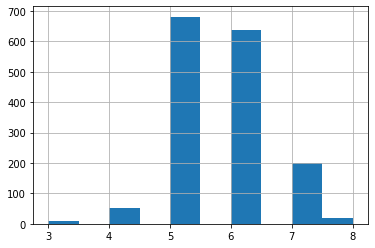

In [2]:
df['quality'].hist()

In [3]:
df['quality_bin'].value_counts(normalize=True)

0    0.86429
1    0.13571
Name: quality_bin, dtype: float64

* If you encounter errors, [this page](https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/index.html) may help.

In [4]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /Users/chriskuo/opt/anaconda3/envs/AD/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/jw/wyhtzlf94zbgtpf9g_n5tryr0000gn/T/tmpgrbdjt41
  JVM stdout: /var/folders/jw/wyhtzlf94zbgtpf9g_n5tryr0000gn/T/tmpgrbdjt41/h2o_chriskuo_started_from_python.out
  JVM stderr: /var/folders/jw/wyhtzlf94zbgtpf9g_n5tryr0000gn/T/tmpgrbdjt41/h2o_chriskuo_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.1
H2O cluster version age:,7 months and 2 days !!!
H2O cluster name:,H2O_from_python_chriskuo_i4lfed
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [5]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [61]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(df,test_size=0.4,random_state=1234)
df_hex = h2o.H2OFrame(df)
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [7]:
predictors = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
              'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
target='quality_bin'

### RF

In [8]:
predictors = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
              'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
target='quality_bin'

from h2o.estimators.random_forest import H2ORandomForestEstimator
RF_modl = H2ORandomForestEstimator(
        model_id = 'RF_modl',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
RF_modl.train(predictors,target,training_frame=train_hex)

drf Model Build progress: |███████████████████████████████████████████████| 100%


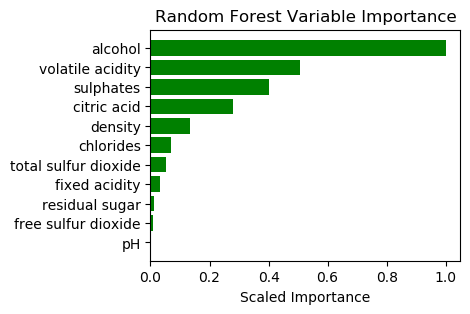

In [9]:
def VarImp(model_name,m_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (4,3))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title(m_name + ' Variable Importance')
    plt.show()
    
VarImp(RF_modl,'Random Forest')


In [10]:
def actual_predict(model,test_hex,target):
    y_pred = model.predict(test_hex).as_data_frame()
    y_actual = test_hex[target].as_data_frame()
    df_actual_predict = pd.concat([y_actual,y_pred],axis=1)
    df_actual_predict.columns = ['actual','pred']
    return(df_actual_predict)
RF_actual_predict = actual_predict(RF_modl,test_hex,target)
RF_actual_predict.head()

drf prediction progress: |████████████████████████████████████████████████| 100%


,actual,pred
0,0,0.068224
1,0,0.047805
2,0,0.156006
3,0,0.137633
4,1,0.253958


In [15]:
# ROC
from sklearn.metrics import roc_curve,roc_auc_score, auc 
from sklearn.metrics import average_precision_score, precision_recall_curve

dd = RF_actual_predict
RF_roc_auc_value = roc_auc_score(dd['actual'],dd['pred'])
RF_roc_auc_value

0.8795414177296949

In [13]:
def gains_table(df_actual_predict):
    df_actual_predict = df_actual_predict.sort_values(by='pred',ascending=False)
    df_actual_predict['row_id'] = range(0,0+len(df_actual_predict))
    
    df_actual_predict['decile'] = (df_actual_predict['row_id'] / (len(df_actual_predict)/10)).astype(int)
    df_actual_predict.loc[df_actual_predict['decile'] == 10] =9
    
    # Create gains table
    gains = df_actual_predict.groupby('decile')['actual'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] - gains['percent_cum_non_actual']  ) * 100 
    gains['gain'] = (gains['cum_actual'] / gains['cum_count']*100).round(2)
    return(gains)
    
RF_gains = gains_table(RF_actual_predict)
RF_gains

,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,64,27,37,64,27,37,0.35,0.07,7.7,3.51,28.0,42.19
1,64,32,32,128,59,69,0.77,0.12,15.4,3.83,65.0,46.09
2,64,5,59,192,64,128,0.83,0.23,23.1,2.77,60.0,33.33
3,64,6,58,256,70,186,0.91,0.33,30.8,2.27,58.0,27.34
4,64,5,59,320,75,245,0.97,0.44,38.5,1.95,53.0,23.44
5,64,0,64,384,75,309,0.97,0.55,46.2,1.62,42.0,19.53
6,64,0,64,448,75,373,0.97,0.66,53.9,1.39,31.0,16.74
7,64,1,63,512,76,436,0.99,0.77,61.6,1.23,22.0,14.84
8,64,1,63,576,77,499,1.00,0.89,69.3,1.11,11.0,13.37


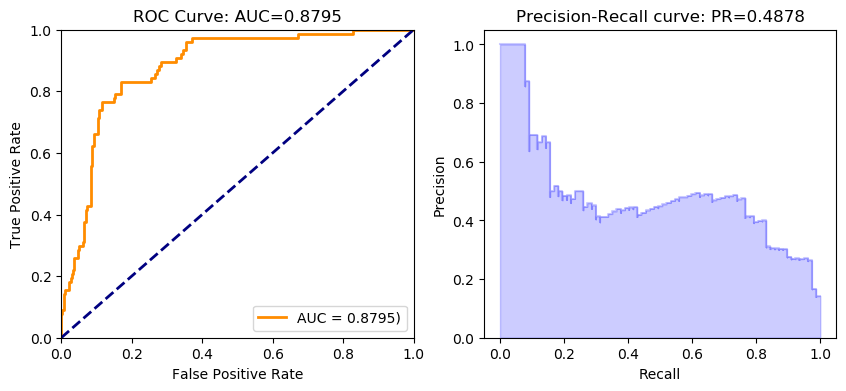

In [14]:
def ROC_PR(df_actual_predict):
    
    # ROC
    from sklearn.metrics import roc_curve,roc_auc_score, auc 
    from sklearn.metrics import average_precision_score, precision_recall_curve

    roc_auc_value = roc_auc_score(df_actual_predict['actual'],df_actual_predict['pred'])
    fpr, tpr, _ = roc_curve(df_actual_predict['actual'],df_actual_predict['pred'])
    roc_auc = auc(fpr,tpr)
    
    import matplotlib.pyplot as plt
    lw=2
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr, color='darkorange',lw=lw,label='AUC = %0.4f)' %roc_auc_value)
    plt.plot([0,1],[0,1], color='navy',lw=lw,linestyle='--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: AUC={0:0.4f}'.format(roc_auc_value))
    plt.legend(loc='lower right')
    
    # Precision-Recall
    plt.subplot(1,2,2)
    average_precision = average_precision_score(df_actual_predict['actual'],df_actual_predict['pred'])
    precision, recall, _ = precision_recall_curve(df_actual_predict['actual'],df_actual_predict['pred'])
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.ylim([0.0,1.05])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    
ROC_PR(RF_actual_predict)

## GBM

In [16]:
from h2o.estimators import H2OGradientBoostingEstimator
GBM_modl = H2OGradientBoostingEstimator(
        model_id = 'GBM_modl',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
GBM_modl.train(predictors,target,training_frame=train_hex)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [18]:
GBM_actual_predict = actual_predict(GBM_modl,test_hex,target)
GBM_gains = gains_table(GBM_actual_predict)
GBM_gains

gbm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,64,32,32,64,32,32,0.42,0.06,7.7,4.16,36.0,50.00
1,64,27,37,128,59,69,0.77,0.12,15.4,3.83,65.0,46.09
2,64,6,58,192,65,127,0.84,0.23,23.1,2.81,61.0,33.85
3,64,2,62,256,67,189,0.87,0.34,30.8,2.18,53.0,26.17
4,64,1,63,320,68,252,0.88,0.45,38.5,1.77,43.0,21.25
5,64,2,62,384,70,314,0.91,0.56,46.2,1.52,35.0,18.23
6,64,2,62,448,72,376,0.94,0.67,53.9,1.34,27.0,16.07
7,64,3,61,512,75,437,0.97,0.78,61.6,1.22,19.0,14.65
8,64,1,63,576,76,500,0.99,0.89,69.3,1.10,10.0,13.19


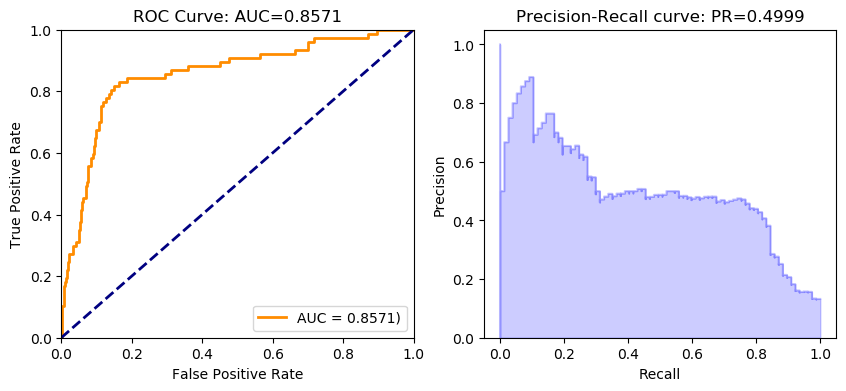

In [19]:
ROC_PR(GBM_actual_predict)

### XGB

In [21]:
from h2o.estimators import H2OXGBoostEstimator
XGB_modl = H2OXGBoostEstimator(
        model_id = 'XGB_modl',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
XGB_modl.train(predictors,target,training_frame=train_hex)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [22]:
XGB_actual_predict = actual_predict(XGB_modl,test_hex,target)
XGB_gains = gains_table(XGB_actual_predict)
XGB_gains

xgboost prediction progress: |████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,64,35,29,64,35,29,0.45,0.05,7.7,4.55,40.0,54.69
1,64,22,42,128,57,71,0.74,0.13,15.4,3.70,61.0,44.53
2,64,8,56,192,65,127,0.84,0.23,23.1,2.81,61.0,33.85
3,64,2,62,256,67,189,0.87,0.34,30.8,2.18,53.0,26.17
4,64,2,62,320,69,251,0.90,0.45,38.5,1.79,45.0,21.56
5,64,3,61,384,72,312,0.94,0.55,46.2,1.56,39.0,18.75
6,64,2,62,448,74,374,0.96,0.66,53.9,1.37,30.0,16.52
7,64,1,63,512,75,437,0.97,0.78,61.6,1.22,19.0,14.65
8,64,0,64,576,75,501,0.97,0.89,69.3,1.08,8.0,13.02


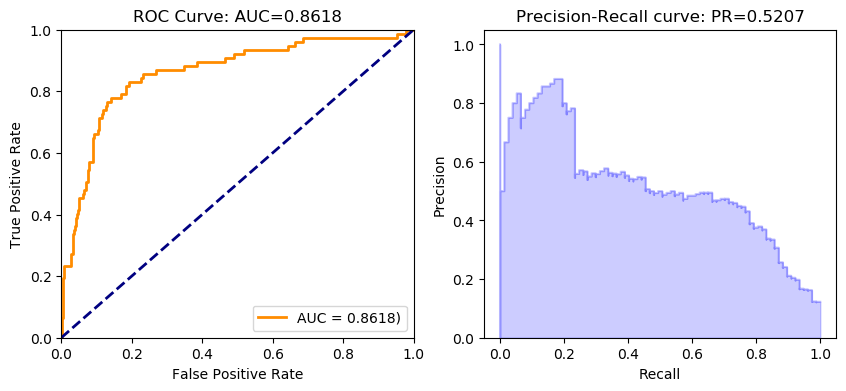

In [23]:
ROC_PR(XGB_actual_predict)

## GLM without Regularization

In [36]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
GLM_WO = H2OGeneralizedLinearEstimator(family= "binomial",
                                          lambda_ = 0,
                                          compute_p_values = True)
GLM_WO.train(predictors, target, training_frame= train_hex)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [38]:
y_pred = GLM_WO.predict(test_hex).as_data_frame()
y_actual = test_hex[target].as_data_frame()
y_pred.head()

glm prediction progress: |████████████████████████████████████████████████| 100%


,predict,p0,p1,StdErr
0,0,0.976211,0.023789,0.416904
1,0,0.974248,0.025752,0.332078
2,0,0.961677,0.038323,0.451065
3,0,0.943027,0.056973,0.400536
4,1,0.510598,0.489402,0.262505


In [70]:
GLM_WO_actual_predict = pd.concat([y_actual,y_pred['predict']],axis=1)
GLM_WO_actual_predict.columns = ['actual','pred']
GLM_WO_actual_predict.head()

GLM_WO_roc_auc_value = roc_auc_score(GLM_WO_actual_predict['actual'],GLM_WO_actual_predict['pred'])
GLM_WO_roc_auc_value

0.7666143802911121

In [42]:
GLM_WO_gains = gains_table(GLM_WO_actual_predict)
GLM_WO_gains

,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,64,24,40,64,24,40,0.31,0.07,7.7,3.12,24.0,37.50
1,64,27,37,128,51,77,0.66,0.14,15.4,3.31,52.0,39.84
2,64,4,60,192,55,137,0.71,0.24,23.1,2.38,47.0,28.65
3,64,4,60,256,59,197,0.77,0.35,30.8,1.92,42.0,23.05
4,64,4,60,320,63,257,0.82,0.46,38.5,1.64,36.0,19.69
5,64,3,61,384,66,318,0.86,0.56,46.2,1.43,30.0,17.19
6,64,3,61,448,69,379,0.90,0.67,53.9,1.28,23.0,15.40
7,64,4,60,512,73,439,0.95,0.78,61.6,1.19,17.0,14.26
8,64,2,62,576,75,501,0.97,0.89,69.3,1.08,8.0,13.02


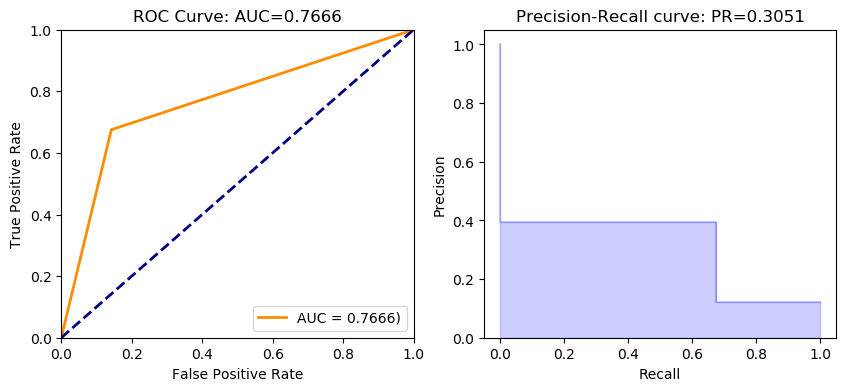

In [43]:
ROC_PR(GLM_WO_actual_predict)

In [72]:
GLM_WITH = H2OGeneralizedLinearEstimator(family= "binomial",
                                          lambda_search = True)
GLM_WITH.train(predictors, target, training_frame= train_hex)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [74]:
y_pred = GLM_WITH.predict(test_hex).as_data_frame()
y_actual = test_hex[target].as_data_frame()
y_pred.head()

glm prediction progress: |████████████████████████████████████████████████| 100%


,predict,p0,p1
0,0,0.975891,0.024109
1,0,0.973392,0.026608
2,0,0.959686,0.040314
3,0,0.940490,0.059510
4,1,0.515253,0.484747


In [75]:
GLM_WITH_actual_predict = pd.concat([y_actual,y_pred['predict']],axis=1)
GLM_WITH_actual_predict.columns = ['actual','pred']
GLM_WITH_actual_predict.head()

GLM_WITH_roc_auc_value = roc_auc_score(GLM_WITH_actual_predict['actual'],GLM_WITH_actual_predict['pred'])
GLM_WITH_roc_auc_value

0.7731078867846185

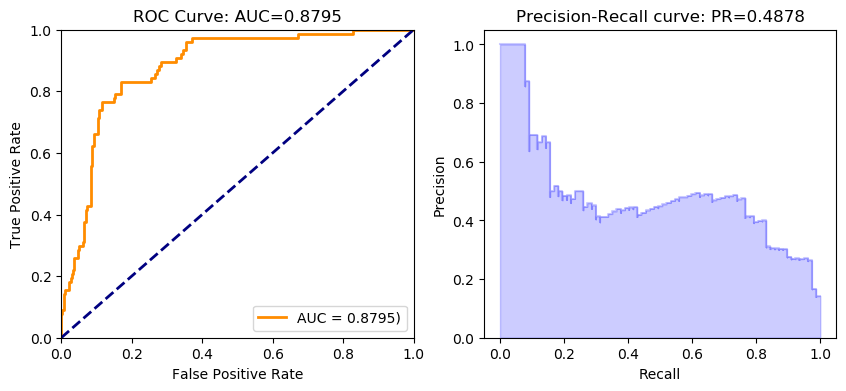

In [131]:
ROC_PR(GLM_WITH_actual_predict)

### DF

In [63]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
DL_modl = H2ODeepLearningEstimator(
    distribution="tweedie",
    activation="RectifierWithDropout",
    hidden=[32,32,32],
    input_dropout_ratio=0.2,
    sparse=True,
    l1=1e-5,
    epochs=10)
DL_modl.train(
    x=predictors,
    y=target,
    training_frame=train_hex,
    validation_frame=test_hex)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [65]:
DL_actual_predict = actual_predict(DL_modl,test_hex,target)
DL_gains = gains_table(DL_actual_predict)
DL_gains

deeplearning prediction progress: |███████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,64,7,57,64,7,57,0.09,0.10,7.7,0.91,1.0,10.94
1,64,4,60,128,11,117,0.14,0.21,15.4,0.71,7.0,8.59
2,64,2,62,192,13,179,0.17,0.32,23.1,0.56,15.0,6.77
3,64,8,56,256,21,235,0.27,0.42,30.8,0.68,15.0,8.20
4,64,7,57,320,28,292,0.36,0.52,38.5,0.73,16.0,8.75
5,64,7,57,384,35,349,0.45,0.62,46.2,0.76,17.0,9.11
6,64,9,55,448,44,404,0.57,0.72,53.9,0.82,15.0,9.82
7,64,12,52,512,56,456,0.73,0.81,61.6,0.91,8.0,10.94
8,64,7,57,576,63,513,0.82,0.91,69.3,0.91,9.0,10.94


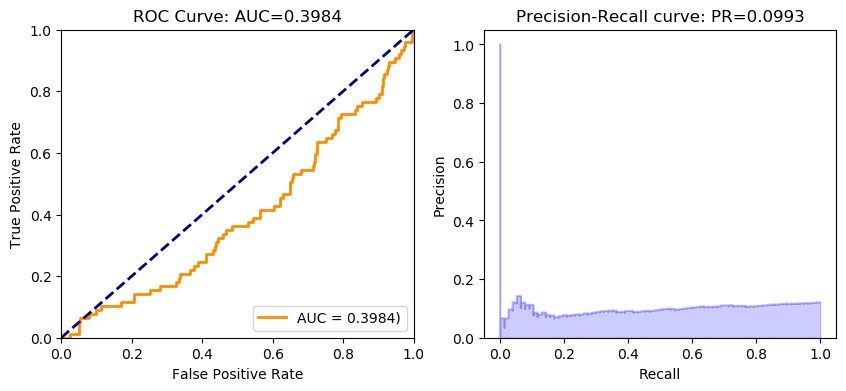

In [66]:
ROC_PR(DL_actual_predict)

### AutoML

In [68]:
from h2o.automl import H2OAutoML
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=predictors, y=target, training_frame=train_hex)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20200718_203605,0.0719626,0.268258,0.0719626,0.151641,0.189068
StackedEnsemble_BestOfFamily_AutoML_20200718_203605,0.0725189,0.269293,0.0725189,0.153493,0.190068
XRT_1_AutoML_20200718_203605,0.0728591,0.269924,0.0728591,0.157032,0.190103
XGBoost_grid__1_AutoML_20200718_203605_model_2,0.0742891,0.27256,0.0742891,0.155334,0.193769
XGBoost_grid__1_AutoML_20200718_203605_model_4,0.0743896,0.272745,0.0743896,0.153243,0.191747
XGBoost_2_AutoML_20200718_203605,0.074413,0.272787,0.074413,0.161897,0.192852
DRF_1_AutoML_20200718_203605,0.0757964,0.275311,0.0757964,0.161527,0.194192
GBM_grid__1_AutoML_20200718_203605_model_1,0.0768497,0.277218,0.0768497,0.167694,0.196235
XGBoost_3_AutoML_20200718_203605,0.0769816,0.277456,0.0769816,0.161524,0.195617
XGBoost_grid__1_AutoML_20200718_203605_model_1,0.0773143,0.278054,0.0773143,0.164993,0.19631
